<a href="https://colab.research.google.com/github/mzohaibnasir/macvds/blob/main/personalcode_bookyDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
print(f"GPU available ", torch.cuda.is_available())

GPU available  True


In [ ]:
 device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
 device

device(type='cuda', index=0)

In [ ]:
# # to save the model to your personal Google Drive, or transfer or upload other files, you need to mount Google Drive. To do this, execute the following in a new cell of the notebook:

# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.activation import LeakyReLU



## Hyperparameters

In [ ]:
z_size = 100
image_size = (28,28)
n_filters = 32
batch_size = 32

## Dataset

In [ ]:
image_path = './'

In [ ]:

transform = transforms.Compose(
    [
        transforms.ToTensor(),
     transforms.Normalize(mean = (0.5), std = (0.5))
    ]
)

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path,
    train=True,
    transform=transform,
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 156726244.53it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 94563383.16it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65177236.58it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6414319.45it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
mnist_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Min: -1.0 Max: 1.0


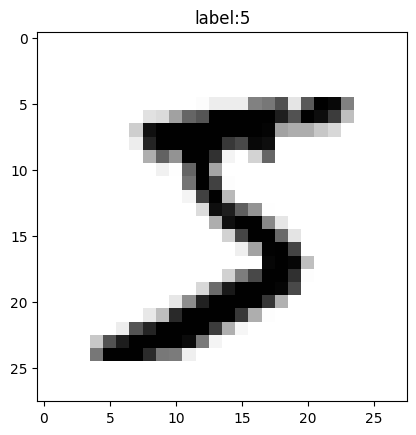

torch.Size([1, 28, 28])


In [ ]:
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
plt.imshow(example.squeeze(),cmap='gray_r')
plt.title(f'label:{label}')
plt.show()
print(example.shape)

In [ ]:
example.shape

torch.Size([1, 28, 28])

In [ ]:
# DataLoader object to load the MNIST dataset in batches. It provides a convenient way to iterate over the dataset in mini-batches during training or evaluation.

from torch.utils.data import DataLoader
dataloader = DataLoader(mnist_dataset,
                        batch_size,
                        shuffle=False,
                        drop_last=True)


Min: -1.0 Max: 1.0


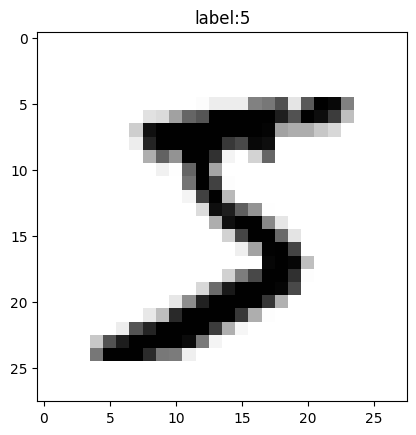

torch.Size([32, 1, 28, 28])


In [ ]:
input_real, label = next(iter(dataloader))
print(f'Min: {input_real.min()} Max: {input_real.max()}')
plt.imshow(input_real[0].squeeze(),cmap='gray_r')
plt.title(f'label:{label[0]}')
plt.show()
print(input_real.shape)

In [ ]:
print(input_real.shape)
input_real = input_real.view(batch_size, -1)
print(input_real.size())
# The returned tensor shares the same data and must have the same number of elements, but may have a different size
# The view() function is a powerful tool for reshaping tensors. It can be used to change the shape of a tensor to better suit the needs of a particular operation. In this case, the view() function is used to flatten the input tensor so that it can be processed with a neural network.

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


## Noise

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1 , 1 ) * 2 - 1
    # 1: The number of channels. 1: The height and width of the image.
    # torch.Size([32, 100, 1, 1])
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1 , 1)
  return input_z


create_noise( 32, 100 ,'uniform').shape

torch.Size([32, 100, 1, 1])

In [ ]:
torch.manual_seed(1)
mode_z='uniform'
z_size = 100

# creating noise
input_z = create_noise(batch_size, z_size, mode_z)
print(f'Input_z--shape: {input_z.shape}')
print(f'Input_real--shape: {input_real.shape}')

Input_z--shape: torch.Size([32, 100, 1, 1])
Input_real--shape: torch.Size([32, 784])


In [ ]:
input_z = torch.randn(32, 100, 1 , 1)
input_z.shape

torch.Size([32, 100, 1, 1])

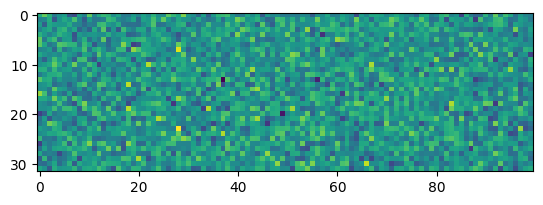

In [ ]:
plt.imshow(input_z.squeeze())

## Generator:



The transposed convolutional layer performs the upsampling operation, followed by Batch Normalization to normalize and stabilize the output. The Leaky ReLU activation function is then applied to introduce non-linearity and allow the network to learn complex representations.



### G(z)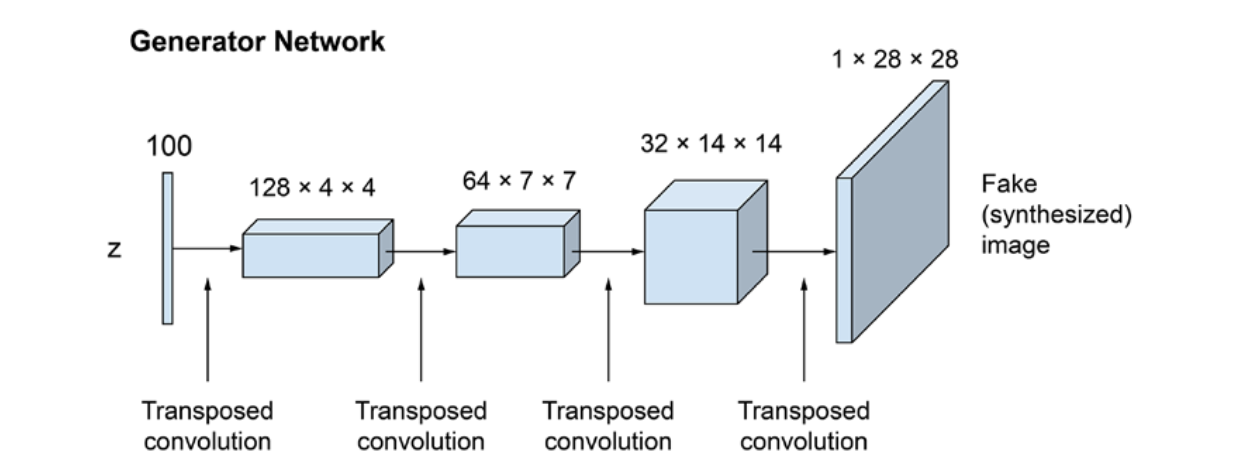

The generator takes a vector, z, of size 100 as input. Then, a series of transposed convolutions using
nn.ConvTranspose2d() upsamples the feature maps until the spatial dimension of the resulting feature
maps reaches 28×28. The number of channels is reduced by half after each transposed convolutional
layer, except the last one, which uses only one output filter to generate a grayscale image. Each transposed convolutional layer is followed by BatchNorm and leaky ReLU activation functions, except the
last one, w""hich uses tanh activation (without BatchNorm).

In [ ]:
"""ConvTranspose2d():


in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int or tuple, optional) – dilation * (kernel_size - 1) - padding zero-padding will be added to both sides of each dimension in the input. Default: 0

"""
def make_generator_network(input_size, n_filters):
  model=nn.Sequential(
   nn.ConvTranspose2d(in_channels=input_size, out_channels =  n_filters * 4 ,
                      kernel_size = 4, stride = 1, padding = 0,
                      bias = False),
   nn.BatchNorm2d( n_filters * 4), #channels
   nn.LeakyReLU(negative_slope=0.2),

   nn.ConvTranspose2d(n_filters * 4, n_filters*2,
                      3, 2, 1, bias = False),
   nn.BatchNorm2d(n_filters * 2),
   nn.LeakyReLU(0.2),


   nn.ConvTranspose2d(n_filters * 2, n_filters,
                      kernel_size = 4, stride = 2, padding=1,
                      bias = False),
   nn.BatchNorm2d(n_filters),
   nn.LeakyReLU(0.2),
   nn.ConvTranspose2d(n_filters, out_channels = 1,
                      kernel_size = 4, stride = 2, padding=1,
                      bias = False),
   nn.Tanh()
  )
  return model



make_generator_network(3,1)

Sequential(
  (0): ConvTranspose2d(3, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

#### When the spatial size of the feature maps increases, the number of feature maps decreases and vice versa.

In addition, note that it’s usually not recommended to use bias units in the layer that follows
a BatchNorm layer. Using bias units would be redundant in this case, since BatchNorm
already has a shift parameter, 𝜷𝜷. You can omit the bias units for a given layer by setting
bias=False in nn.ConvTranspose2d or nn.Conv2d

This is a common practice in transposed convolutional networks, where the number of channels is typically increased through each convolutional layer and decreased through each transposed convolutional layer. Transposed convolutional layers, also known as deconvolutional or upsampling layers, are often used to increase the spatial dimensions of the input. Along with the increase in spatial dimensions, they can also increase the number of channels if desired. However, it is common to reduce the number of channels by half after each transposed convolutional layer to control the model's capacity and prevent overfitting.

Finally, the last transposed convolutional layer in the network uses a tanh activation function without BatchNorm. The hyperbolic tangent function is commonly used for tasks such as image generation because it squashes the output between -1 and 1, providing a good range for representing image pixel values.

## Discriminator
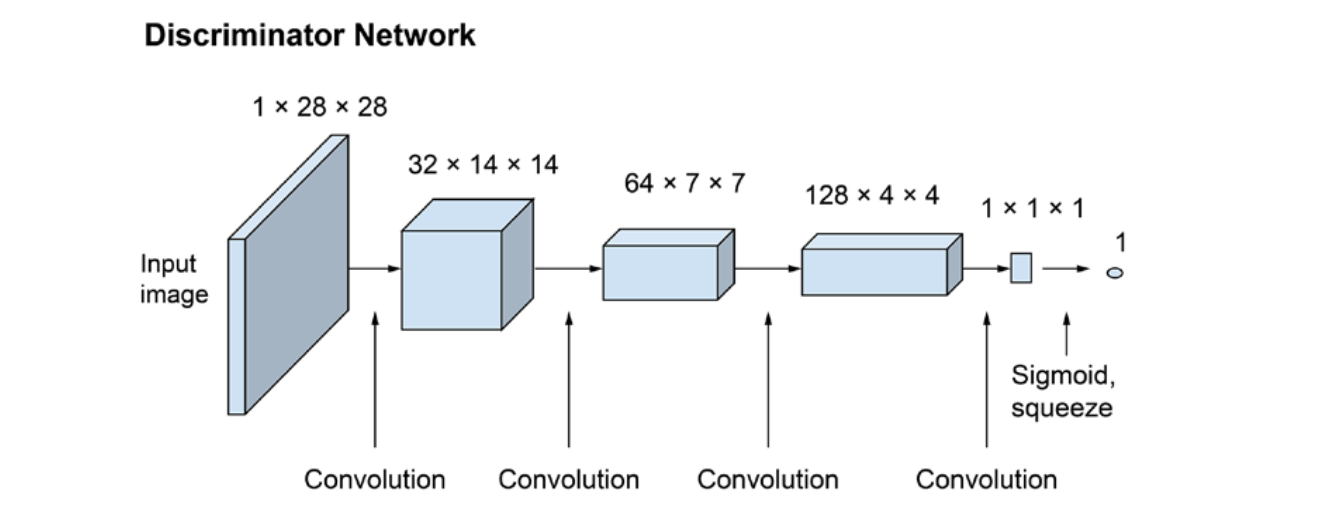

The discriminator receives images of size 1×28×28, which are passed through four convolutional
layers. The first three convolutional layers reduce the spatial dimensionality by 4 while increasing
the number of channels of the feature maps. Each convolutional layer is also followed by BatchNorm
and leaky ReLU activation. The last convolutional layer uses kernels of size 7×7 and a single filter to
reduce the spatial dimensionality of the output to 1×1×1. Finally, the convolutional output is followed
by a sigmoid function and squeezed to one dimension:

### D(G(z))

In [ ]:
"""
in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

"""


# n_filters = 2

class Discriminator(nn.Module):


  def __init__(self, n_features):
    super().__init__()
    # self.n_filters = 2
    self.network = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels= n_filters,
                  kernel_size = 4, stride = 2, padding = 1,
                  bias = False),
        nn.LeakyReLU(0.2),

        nn.Conv2d( n_filters, n_filters * 2,
                 kernel_size = 4, stride = 2,padding = 1,
                 bias = False),
        nn.BatchNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),

        nn.Conv2d( n_filters * 2, n_filters * 4,
                 kernel_size = 3, stride = 2, padding =1,
                 bias = False),
        nn.BatchNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_features * 4, 1,
                 kernel_size = 4, stride = 1, padding = 0,
                 bias = False),

        nn.Sigmoid()


    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1 , 1 ).squeeze(dim=0) # 0 - if given, the input will be squeezed only in the specified dimensions.

# The squeeze() function is necessary because the view() function can sometimes create tensors with dimensions of size 1. These dimensions are unnecessary, and they can cause problems when you try to use the tensor in other operations.
# squeeze() function in PyTorch removes any dimensions of size 1 from a tensor. This is useful because dimensions of size 1 are unnecessary and can cause problems when you try to use the tensor in other operations.


# x = Discriminator(3)
# print(x)

# print(torch.tensor(x).size())


In [ ]:
 """
The view(-1) function in PyTorch tells PyTorch to automatically determine the size of the dimension.
In the case of v.view(-1,1), (n, 1)
for v.view(1,-1), (1,n)

"""
v = torch.tensor([1,2,3,4,5,6,7,])
print(v.view(-1).shape)
print(v.view(-1,1).shape)
print(v.view(1,-1).shape)

print("Squeeze(0)")
print(v.view(-1).squeeze(0).shape)
print(v.view(-1,1).squeeze(0).shape)
print(v.view(1,-1).squeeze(0).shape)

torch.Size([7])
torch.Size([7, 1])
torch.Size([1, 7])
Squeeze(0)
torch.Size([7])
torch.Size([7, 1])
torch.Size([7])


## Action

### models

In [ ]:

gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [ ]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### loss fn

In [ ]:
loss_fn = nn.BCELoss()

g_optimizer = torch.optim.Adam( gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam( disc_model.parameters(), 0.0002)

In [ ]:
print(g_optimizer, d_optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
) Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


### Training

In [ ]:
# train generator
def g_train(x):
  gen_model.zero_grad()

  batch_size = x.size(0)

  input_z = create_noise( batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones((batch_size,1), device = device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn( d_proba_fake, g_labels_real)

  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()


#  for x, _ in range(dataloader)

x, _ = next(iter(dataloader))

print(x.shape)

# dataloader
g_train(x)

torch.Size([32, 1, 28, 28])


0.6992074251174927

In [ ]:
len(dataloader)

1875

In [ ]:
def d_train(x):
  disc_model.zero_grad()


  # train descriminator on real batch
  batch_size = x.size(0)
  x=x.to(device)
  d_labels_real = torch.ones(batch_size, 1, device = device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # train descriminator on fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output =gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device = device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize ONLY D's parameters
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [ ]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)


def create_samples(g_model, input_z):
  g_output = g_model(input_z.to(device))
  # print(f'g_output: {g_output.size()}')
  images = torch.reshape( g_output, (batch_size, *image_size))

  return (images+1)/2.0

print(create_samples(gen_model, input_z).size())

torch.Size([32, 28, 28])


In [ ]:
epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses =[],[]
  for i, (x, _) in enumerate(dataloader):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_train(x))
  print(f'Epoch {epoch:03d} | Avg Losses >>  G/D {torch.FloatTensor(g_losses).mean():.4f}{torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_samples.append(
      create_samples(gen_model, fixed_z).detach().cpu().numpy()
      )


Epoch 001 | Avg Losses >>  G/D 4.20500.1959
Epoch 002 | Avg Losses >>  G/D 2.93680.4390
Epoch 003 | Avg Losses >>  G/D 2.74300.4540
Epoch 004 | Avg Losses >>  G/D 2.67610.4525
Epoch 005 | Avg Losses >>  G/D 2.57540.4810
Epoch 006 | Avg Losses >>  G/D 2.68210.4334
Epoch 007 | Avg Losses >>  G/D 2.85570.3885
Epoch 008 | Avg Losses >>  G/D 2.96390.3539
Epoch 009 | Avg Losses >>  G/D 3.12250.3190
Epoch 010 | Avg Losses >>  G/D 3.28930.2881
Epoch 011 | Avg Losses >>  G/D 3.46510.2687
Epoch 012 | Avg Losses >>  G/D 3.54120.2526
Epoch 013 | Avg Losses >>  G/D 3.60730.2474
Epoch 014 | Avg Losses >>  G/D 3.71170.2378
Epoch 015 | Avg Losses >>  G/D 3.75840.2177
Epoch 016 | Avg Losses >>  G/D 3.83890.2249
Epoch 017 | Avg Losses >>  G/D 3.92090.2310
Epoch 018 | Avg Losses >>  G/D 3.96940.2162
Epoch 019 | Avg Losses >>  G/D 3.93990.2233
Epoch 020 | Avg Losses >>  G/D 4.13030.1889
Epoch 021 | Avg Losses >>  G/D 4.14440.1994
Epoch 022 | Avg Losses >>  G/D 4.35600.1774
Epoch 023 | Avg Losses >>  G/D 4

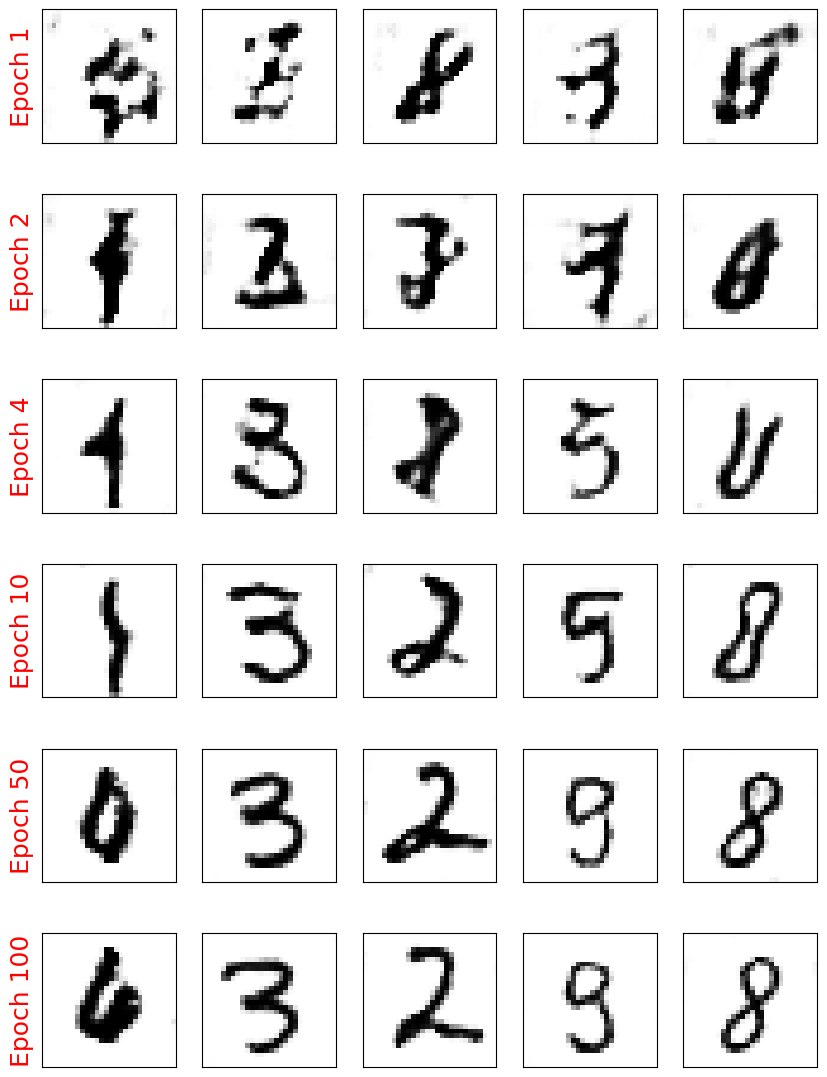

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()